In [32]:
import sys, os
import time
import re
import itertools
import numpy as np
import numpy.linalg as npl
import scipy as sp
import scipy.interpolate
import yaml
import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#from mpl_toolkits.axes_grid1 import Grid
import matplotlib.gridspec as gridspec


%matplotlib inline

In [34]:
#sns.set_style('whitegrid')
sns.set_style('ticks')

In [35]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Zigzag

In [36]:
%popd

UsageError: %popd on empty stack


In [37]:

%pushd Results/os_zigzag

/Users/lee.8024/Dropbox/code/TMDStrip/Results/os_zigzag


['~/Dropbox/code/TMDStrip']

In [38]:
try:
    with open('params.cache.pickle', 'rb') as inputfile:
        params = pickle.load(inputfile)
except FileNotFoundError as e:
    params = dict()

try:
    with open('solutions.cache.pickle', 'rb') as inputfile:
        solutions = pickle.load(inputfile)
except FileNotFoundError as e:
    solutions = dict()

In [39]:
for _, param in params.items():
    break

In [40]:
orbitals = param["UnitCell"]["Orbitals"]

latticevectors = np.array( param["UnitCell"]["LatticeVectors"] )

orbital_lookup = dict()
orbital_list = dict()

for orb in orbitals:
    fc = np.array(orb['Coord']['whole']) + np.array(orb['Coord']['fraction'])
    cc = np.dot(fc, latticevectors)
    orbital_lookup[tuple(orb['Name'])] = cc
    orbital_list[orb['Index']] = {'Name': tuple(orb['Name']), 'Coord': cc}

registry = param['Registry']
Delta_list = dict()
for Delta in registry['Delta']:
    Delta_list[Delta['Index']] = { 'Row': Delta['Row'], 'Col': Delta['Col'], 'Vec': Delta['Vec'] }

b1 = latticevectors[0,:]
b2 = latticevectors[1,:]

In [41]:
is_equal_spin_pairings = np.zeros(len(Delta_list), dtype=bool)
is_opposite_spin_pairings = np.zeros(len(Delta_list), dtype=bool)

In [42]:
is_equal_spin_pairings = np.zeros(len(Delta_list), dtype=bool)
is_opposite_spin_pairings = np.zeros(len(Delta_list), dtype=bool)

for k, v in Delta_list.items():
    row_name = orbital_list[v['Row']]['Name']
    col_name = orbital_list[v['Col']]['Name']
    row_spin = row_name[2]
    col_spin = col_name[2]
    if row_spin == col_spin:
        is_equal_spin_pairings[k-1] = True
    else:
        is_opposite_spin_pairings[k-1] = True

In [43]:
def maxzero(arr):
    if arr is not None and (len(arr) > 0):
        return np.max(np.abs(arr))
    else:
        return 0.0

datapoints = []
for k in sorted(params.keys()):
    if not solutions[k]['Delta']:
        continue
    try:
        param = params[k]
        sol = solutions[k]
        lambdaIsing = param["Parameters"]["IsingSpinOrbitCoupling"]
        chargeTransferEnergy = param["Parameters"]["ChargeTransferEnergy"]
        onSiteInteraction = param["Parameters"]["OnSiteInteraction"]
        nearestNeighborInteraction = param["Parameters"]["NearestNeighborInteraction"]
        Deltas = np.array( sol['Delta'] )
        #print("A")
        #print(Deltas[is_equal_spin_pairings])
        #print("B")
        maxDelta = maxzero(Deltas)
        maxDeltaESP = maxzero(Deltas[is_equal_spin_pairings])
        maxDeltaOSP = maxzero(Deltas[is_opposite_spin_pairings])  
        rmsDelta = np.sqrt(np.median(np.abs(Deltas)**2))
        maxDiff_t = sol['MaxDiff_t']
        if maxDiff_t > (np.finfo(np.float64).eps)**(1.0/4.0):
            #print("{} not converged".format(k))
            #continue
            #maxDelta = 0.0
            #maxDeltaESP = 0.0
            #maxDeltaOSP = 0.0
            pass
        #print(maxDelta)
        datapoints.append((chargeTransferEnergy,
                           np.round(onSiteInteraction, 3),
                           np.round(nearestNeighborInteraction, 3),
                           maxDelta,
                           maxDeltaESP,
                           maxDeltaOSP,
                          rmsDelta))
    except TypeError as e:
        print(e)
        pass
datapoints = np.array(sorted(datapoints), dtype=[('mAB', float),
                                                 ('U', float),
                                                 ('V', float), 
                                                 ('Delta', float),
                                                 ('DeltaESP', float),
                                                 ('DeltaOSP', float),
                                                 ('RmsDelta', float),
                                                ])

In [44]:
datapoints

array([ ( 0.   , -4.  ,  0.,   1.55021147e+00,   1.55021147e+00,  0.,   1.34197114e+00),
       ( 0.   , -3.9 ,  0.,   1.49098351e+00,   1.49098351e+00,  0.,   1.27805607e+00),
       ( 0.   , -3.8 ,  0.,   1.43143882e+00,   1.43143882e+00,  0.,   1.21348204e+00),
       ( 0.   , -3.7 ,  0.,   1.37157133e+00,   1.37157133e+00,  0.,   1.14818553e+00),
       ( 0.   , -3.6 ,  0.,   1.31137792e+00,   1.31137792e+00,  0.,   1.08209191e+00),
       ( 0.   , -3.5 ,  0.,   1.25085975e+00,   1.25085975e+00,  0.,   1.01511315e+00),
       ( 0.   , -3.4 ,  0.,   1.19002426e+00,   1.19002426e+00,  0.,   9.47142542e-01),
       ( 0.   , -3.3 ,  0.,   1.12888787e+00,   1.12888787e+00,  0.,   8.78051705e-01),
       ( 0.   , -3.2 ,  0.,   1.06747981e+00,   1.06747981e+00,  0.,   8.07682742e-01),
       ( 0.   , -3.1 ,  0.,   1.00584754e+00,   1.00584754e+00,  0.,   7.35839345e-01),
       ( 0.   , -3.  ,  0.,   9.44064328e-01,   9.44064328e-01,  0.,   6.62274462e-01),
       ( 0.   , -2.9 ,  0.,   8

In [45]:
select_datapoints = datapoints[ np.isclose( datapoints["mAB"], 0.000 ) ]

In [46]:
xs_zigzag = select_datapoints['U']
ys_zigzag = select_datapoints['Delta']
y2s_zigzag = select_datapoints['RmsDelta']

## Armchair

In [47]:
%popd

/Users/lee.8024/Dropbox/code/TMDStrip
popd -> ~/Dropbox/code/TMDStrip


In [48]:

%pushd Results/os_armchair

/Users/lee.8024/Dropbox/code/TMDStrip/Results/os_armchair


['~/Dropbox/code/TMDStrip']

In [49]:
try:
    with open('params.cache.pickle', 'rb') as inputfile:
        params = pickle.load(inputfile)
except FileNotFoundError as e:
    params = dict()

try:
    with open('solutions.cache.pickle', 'rb') as inputfile:
        solutions = pickle.load(inputfile)
except FileNotFoundError as e:
    solutions = dict()

In [50]:
for _, param in params.items():
    break

In [51]:
orbitals = param["UnitCell"]["Orbitals"]

latticevectors = np.array( param["UnitCell"]["LatticeVectors"] )

orbital_lookup = dict()
orbital_list = dict()

for orb in orbitals:
    fc = np.array(orb['Coord']['whole']) + np.array(orb['Coord']['fraction'])
    cc = np.dot(fc, latticevectors)
    orbital_lookup[tuple(orb['Name'])] = cc
    orbital_list[orb['Index']] = {'Name': tuple(orb['Name']), 'Coord': cc}

registry = param['Registry']
Delta_list = dict()
for Delta in registry['Delta']:
    Delta_list[Delta['Index']] = { 'Row': Delta['Row'], 'Col': Delta['Col'], 'Vec': Delta['Vec'] }

b1 = latticevectors[0,:]
b2 = latticevectors[1,:]

In [52]:
is_equal_spin_pairings = np.zeros(len(Delta_list), dtype=bool)
is_opposite_spin_pairings = np.zeros(len(Delta_list), dtype=bool)

In [53]:
is_equal_spin_pairings = np.zeros(len(Delta_list), dtype=bool)
is_opposite_spin_pairings = np.zeros(len(Delta_list), dtype=bool)

for k, v in Delta_list.items():
    row_name = orbital_list[v['Row']]['Name']
    col_name = orbital_list[v['Col']]['Name']
    row_spin = row_name[2]
    col_spin = col_name[2]
    if row_spin == col_spin:
        is_equal_spin_pairings[k-1] = True
    else:
        is_opposite_spin_pairings[k-1] = True

In [54]:
def maxzero(arr):
    if arr is not None and (len(arr) > 0):
        return np.max(np.abs(arr))
    else:
        return 0.0

datapoints = []
for k in sorted(params.keys()):
    if not solutions[k]['Delta']:
        continue
    try:
        param = params[k]
        sol = solutions[k]
        lambdaIsing = param["Parameters"]["IsingSpinOrbitCoupling"]
        chargeTransferEnergy = param["Parameters"]["ChargeTransferEnergy"]
        onSiteInteraction = param["Parameters"]["OnSiteInteraction"]
        nearestNeighborInteraction = param["Parameters"]["NearestNeighborInteraction"]
        Deltas = np.array( sol['Delta'] )
        #print("A")
        #print(Deltas[is_equal_spin_pairings])
        #print("B")
        maxDelta = maxzero(Deltas)
        maxDeltaESP = maxzero(Deltas[is_equal_spin_pairings])
        maxDeltaOSP = maxzero(Deltas[is_opposite_spin_pairings])  
        rmsDelta = np.sqrt(np.median(np.abs(Deltas)**2))
        maxDiff_t = sol['MaxDiff_t']
        if maxDiff_t > (np.finfo(np.float64).eps)**(1.0/4.0):
            #print("{} not converged".format(k))
            #continue
            #maxDelta = 0.0
            #maxDeltaESP = 0.0
            #maxDeltaOSP = 0.0
            pass
        #print(maxDelta)
        datapoints.append((chargeTransferEnergy,
                           np.round(onSiteInteraction, 3),
                           np.round(nearestNeighborInteraction, 3),
                           maxDelta,
                           maxDeltaESP,
                           maxDeltaOSP,
                          rmsDelta))
    except TypeError as e:
        print(e)
        pass
datapoints = np.array(sorted(datapoints), dtype=[('mAB', float),
                                                 ('U', float),
                                                 ('V', float), 
                                                 ('Delta', float),
                                                 ('DeltaESP', float),
                                                 ('DeltaOSP', float),
                                                 ('RmsDelta', float),
                                                ])

In [55]:
select_datapoints = datapoints[ np.isclose( datapoints["mAB"], 0.000 ) ]

In [56]:
xs_armchair = select_datapoints['U']
ys_armchair = select_datapoints['Delta']
y2s_armchair = select_datapoints['RmsDelta']

In [57]:
Uc_bulk = 2.31950969

In [58]:
%popd

/Users/lee.8024/Dropbox/code/TMDStrip
popd -> ~/Dropbox/code/TMDStrip


''

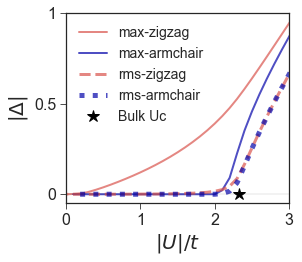

In [70]:
fig = plt.figure(figsize=(4, 3.5))

ax = fig.gca()
ax.plot(np.abs(xs_zigzag),   ys_zigzag,    '-' , label='max-zigzag',   linewidth=2, alpha=0.7, color=sns.xkcd_rgb['pale red'])
ax.plot(np.abs(xs_armchair), ys_armchair,  '-' , label='max-armchair', linewidth=2, alpha=0.7, color=sns.xkcd_rgb['royal blue'])
ax.plot(np.abs(xs_zigzag),   y2s_zigzag,   '--', label='rms-zigzag',   linewidth=3, alpha=0.7, color=sns.xkcd_rgb['pale red'])
ax.plot(np.abs(xs_armchair), y2s_armchair, ':' , label='rms-armchair', linewidth=5, alpha=0.7, color=sns.xkcd_rgb['royal blue'])

ax.set_xlim(0,3)

ax.set_ylim(-0.05, 1)
ax.axhline(0, linewidth=0.1, color='k')
ax.plot([Uc_bulk], [0], marker='*', color=sns.xkcd_rgb['black'], zorder=100, markersize=12,
        linestyle='None', label='Bulk Uc')

ax.set_xlabel(r'$|U|/t$', fontsize=20)
ax.set_ylabel(r'$|\Delta|$', fontsize=20)

#ax.grid('off')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["0", "1", "2", "3"], fontsize=16)

#ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
#ax.set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"], fontsize=16)
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(["0", "0.5", "1"], fontsize=16)

"""
ax.annotate(r'Bulk $U_c$', xy=(Uc_bulk+0.01, +0.01), xytext=(2.35, 0.05),
            horizontalalignment='left',
            arrowprops=dict(facecolor=sns.xkcd_rgb['pale red'],
                            edgecolor='none',
                            width=4,
                            headlength=8,
                            headwidth=8,
                            alpha=0.7),
            fontsize=14, color=sns.xkcd_rgb['pale red'], alpha=1)
"""
ax.legend(fontsize=14, loc=2)


plt.savefig('onsite_zigzag_vs_armchair.png', dpi=300, bbox_inches='tight')
plt.savefig('onsite_zigzag_vs_armchair.pdf', dpi=300, bbox_inches='tight')
;

In [69]:
mv *.pdf /Users/lee.8024/Dropbox/workspace/

''

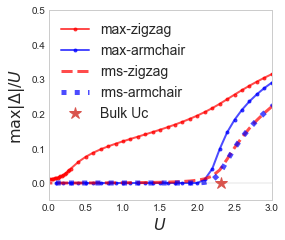

In [37]:
fig = plt.figure(figsize=(4, 3.5))

ax = fig.gca()
ax.plot(np.abs(xs_zigzag),   ys_zigzag/np.abs(xs_zigzag),    'r.-' , label='max-zigzag',   linewidth=2, alpha=0.7)
ax.plot(np.abs(xs_armchair), ys_armchair/np.abs(xs_armchair),  'b.-' , label='max-armchair', linewidth=2, alpha=0.7)
ax.plot(np.abs(xs_zigzag),   y2s_zigzag/np.abs(xs_zigzag),   'r--', label='rms-zigzag',   linewidth=3, alpha=0.7)
ax.plot(np.abs(xs_armchair), y2s_armchair/np.abs(xs_armchair), 'b:', label='rms-armchair', linewidth=5, alpha=0.7)

ax.set_xlim(0,3)

ax.set_xlabel(r'$U$', fontsize=16)
ax.set_ylabel(r'$\max |\Delta| / U $', fontsize=16)

ax.grid('off')
ax.set_ylim(-0.05, 0.5)
ax.axhline(0, linewidth=0.1, color='k')
ax.plot([Uc_bulk], [0], marker='*', color=sns.xkcd_rgb['pale red'], zorder=100, markersize=12,
        linestyle='None', label='Bulk Uc')
"""
ax.annotate(r'Bulk $U_c$', xy=(Uc_bulk+0.01, +0.01), xytext=(2.35, 0.05),
            horizontalalignment='left',
            arrowprops=dict(facecolor=sns.xkcd_rgb['pale red'],
                            edgecolor='none',
                            width=4,
                            headlength=8,
                            headwidth=8,
                            alpha=0.7),
            fontsize=14, color=sns.xkcd_rgb['pale red'], alpha=1)
"""
ax.legend(fontsize=14, loc=2)
#ax.set_xlim(0,0.5)
#ax.set_ylim(0,0.1)
plt.savefig('onsite_zigzag_vs_armchair_pairamplitude.png', dpi=300, bbox_inches='tight')
;